I use qiskit libraries.It is the open code in Python language created by IBM for simulation of Quantum Algorithms. 
It is recommended installing Anaconda, a cross-platform Python distribution for scientific computing. Jupyter, included in Anaconda,  for interacting with Qiskit.



Install the Qiskit package, which includes Terra, Aer, Ignis, and Aqua:

<i><b>pip install qiskit</i></b>

### Task 1 
This code is to solve the problem proposed in Task 1. The problem was proposed with a quantum circuit of 4 qubits and I have developed it using the number of qubits as a parameter (n)

### Initalizaton, Libraries

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.quantum_info import Statevector, random_statevector
from math import pi
import numpy as np
from matplotlib import pyplot as plt
import scipy #Libry use for optimization algorithms

### Circuit creation functions

I have defined two functions to contruct the quantum circuit, get_var_qc(params,n,L) to construct the circuit with the RX,RZ and CZ gates. And get_var_qc_ugates(params,n,L) to construct the circuit with U_odds gates made by RXs gates and U_evens gates made by RZs and CZs gates.The one I chose to run the program is get_var_qc_ugates(params,n,L) since I think is more accurate to the description of the task.Inside get_var_qc_ugates(params,n,L) there are two more functions: convert_circuit_to_odd_gate(counter_gate,circuit,n,params,counter_layer,j) and convert_circuit_to_even_gate(counter_gate,circuit,n,params,counter_layer,j) which respectevely convert RXs gates to U_odd gates and RZs,CZs gates to U_even gates.

In [2]:
#Args are params: vector of the parameters thetha_i_n, n: number of qubits, L: number of layers
    
def get_var_qc(params,n,L):  
    #qreg is a quantum register with n qubits
    qreg=QuantumRegister(n,name='qreg') 
    #qc is a quantum circuit created with the quantum register qreg
    qc=QuantumCircuit(qreg)
    #the circuit is initialized with all the qubits to 0 with reset
    qc.reset(qreg)
    qc.barrier()
    #counter_layer is a counter to start in the appropiate index of the vector of parameters
    #for each iteration of L (number of layers)
    counter_layer=0
    for j in range(L):
        for i in range(n):
            #rotation x gate in each qubit with each parameter for each layer
            qc.rx(params[i+counter_layer],qreg[i])
        qc.barrier()
        for i in range(n):
            #rotation z gate in each qubit with each parameter for each layer
            qc.rz(params[i+n+counter_layer],qreg[i])
        #cz gates apply for n qubits. counter_bits is a counter to start in the correct qubit for each iteration in range (n-1)
        counter_bits=0
        for l in range(n-1):
            counter_bits+=1
            for j in range(n-counter_bits):
                #cz gates
                qc.cz(l,j+counter_bits)
        qc.barrier()
        #counter_layer is incremented by 2*n since there is one parameter per qubit in each gate and there are 2 gates per layer
        counter_layer+=(2*n)
    return qc

In [3]:
#Args are params:counter_gate: counter +1 for each layer, used to identify the gate number of the circuit 
#circuit: circuit in which the U_gates are appended
#n: number of qubits,vector of the parameters thetha_i_n,
#counter_layer is a counter to start in the appropiate index of the vector of parameters 
#for each iteration of L (number of layers) 
#j is a counter of a layer in the circuit, j=range(L)

def convert_circuit_to_odd_gate(counter_gate,circuit,n,params,counter_layer,j):
    #qreg is a quantum register with n qubits
    qreg=QuantumRegister(n,name='qreg')
     #qc is a quantum circuit created with the quantum register qreg, and its name is U_numbergate
    qc=QuantumCircuit(qreg,name='U_' + str(counter_gate+j+1))
    for i in range(n):
        #rotation x gate in each qubit with each parameter for each layer
        qc.rx(params[i+counter_layer],qreg[i])
    #the Rxs gates applied to the n qubits are transoform into a gate call U_odd
    U_odd=qc.to_gate()
    #The U_odd gate is applied to the quantum circuit called circuit
    circuit.append(U_odd,qreg)
    return circuit

def convert_circuit_to_even_gate(counter_gate,circuit,n,params,counter_layer,j):
     #qreg is a quantum register with n qubits
    qreg=QuantumRegister(n,name='qreg')
    #qc is a quantum circuit created with the quantum register qreg, and its name is U_numbergate
    qc=QuantumCircuit(qreg,name='U_' + str(counter_gate+j+2))
    for i in range(n):
        #rotation z gate in each qubit with each parameter for each layer
        qc.rz(params[i+n+counter_layer],qreg[i])
         #cz gates apply for n qubits. counter_bits is a counter to start in the correct qubit for each iteration in range (n-1)
        counter_bits=0
    for l in range(n-1):
        counter_bits+=1
        for j in range(n-counter_bits):
             #cz gates
            qc.cz(l,j+counter_bits)
    #the RZs gates and CZs gates applied to the n qubits are transoform into a gate call U_even
    U_even=qc.to_gate()
     #The U_even gate is applied to the quantum circuit called circuit
    circuit.append(U_even,qreg)
    return circuit      

#Args are params: vector of the parameters thetha_i_n, n: number of qubits, L: number of layers

def get_var_qc_ugates(params,n,L):
    #qreg is a quantum register with n qubits
    qreg=QuantumRegister(n,name='qreg')
     #circuit is a quantum circuit created with the quantum register qreg
    circuit=QuantumCircuit(qreg,name='circuit')
     #the circuit is initialized with all the qubits to 0 with reset
    circuit.reset(qreg)
    #Initialize counter_layer
    counter_layer=0
     #Initialize counter_gate
    counter_gate=0
    #For each layer of the circuit a U_odd and a U_even gate are applied 
    for j in range(L):
        circuit=convert_circuit_to_odd_gate(counter_gate,circuit,n,params,counter_layer,j)
        circuit=convert_circuit_to_even_gate(counter_gate,circuit,n,params,counter_layer,j)
        counter_gate+=1
        #counter_layer is incremented by 2*n since there is one parameter per qubit in each gate and there are 2 gates per layer
        counter_layer+=(2*n)
    return circuit


### Cost function

In [4]:
#Args are params: vector of the parameters thetha_i_n, n: number of qubits, L: number of layers,
#dims: length of statevectector= 2**n 
def objective_function(params,n,L,dims):
    # Obtain a quantum circuit instance from the parameters, with n qubits and L layers
    qc = get_var_qc_ugates(params,n,L)
    # Execute the quantum circuit to obtain the output state vector associated with the current parameters
    result = execute(qc, backend).result()
    # Obtain the outputstate, output state vector of the quantum circuit 
    outputstate = result.get_statevector(qc)
    # Calculate the cost as the distance between the output state vector and the random target state vector to the power of 2
    #np.abs(complex_number)=modulus of complex number so we are calculating the sum of the modulus to the power of two 
    #of each component of the vector which is the outputstate vector with the parameters of our circucit minus the objective 
    #random generated statevector
    cost = sum([((np.abs(outputstate[i] - target_statevector[i]))**2) for i in range(dims)])
    return cost

### Backend (StateVector Simulation)

In [5]:
#simulator to calculate the state_vector of a quantum circuit
backend=Aer.get_backend(name='statevector_simulator')

### Number of qubits selection & random state vector creation

In [6]:
# the dimension of the state vector is equal to 2**n,  n=number of qubits
n=4 
dims=2**n
#Creation of the random objective state_vector
target_statevector=random_statevector(dims).data

### L-BFGS-B Optimization Algorithm
I have selected this optimization algorithm since it allows to implement boundaries to the parameters

In [8]:
#Initialization of a list to retrieve the cost function final values for each layer value
f_values=[] 
#List of number of layers
L_values=[1,2,3,4,5,10,20,50] 
for L in L_values:
    #number of parameters
    n_variables=2*n*L
    #Random  parameters between 0-2pi, length equal to the number of parameter 2*n*L 
    #In each layer L there are 2 gates and in each gate n,number of qubits parameters
    params=np.random.uniform(0,2*pi,n_variables)
  
    #Boundary of the parameters, values between 0-2pi
    bound = tuple((0, 2*pi) for x in range (len(params))) 
    #Optimization Algorithm. Arguments are objective_function, parameters, optimization method applid, boundaries and tolerance.
    opts = scipy.optimize.minimize(objective_function, params, args=(n,L,dims),method='L-BFGS-B',tol=0.0001,bounds=bound,
                                   options={'maxiter':1000})
                                  
    success=opts.success
    status=opts.status
    message=opts.message
    #Value of the cost function with the final value of the parameters
    f=opts.fun 
    print('Cost_Function_Value: {}, Success: {}, Status: {}, Message: {}'.format(f,success,status,message))
    f_values.append(f)

Cost_Function_Value: 0.8051728673984399, Success: True, Status: 0, Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Cost_Function_Value: 0.4350931842684961, Success: True, Status: 0, Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Cost_Function_Value: 0.07609470424576387, Success: True, Status: 0, Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Cost_Function_Value: 0.005136722476547207, Success: True, Status: 0, Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Cost_Function_Value: 0.00498666506886015, Success: True, Status: 0, Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Cost_Function_Value: 0.00042041426279361817, Success: True, Status: 0, Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Cost_Function_Value: 0.00017138670967950398, Success: True, Status: 0, Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Cost_Function_Value: 1.374374222506122e-06, Success: True, Status: 0, Message: b'CONVERGENCE: REL_R

### Plot results 

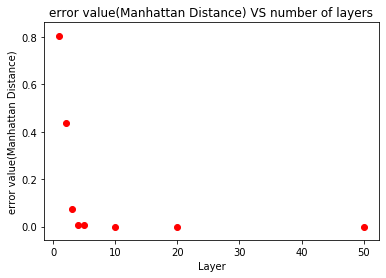

In [9]:
plt.scatter(L_values,f_values,color='red')
plt.xlabel("Layer")
plt.ylabel("error value(Manhattan Distance)")
plt.title('error value(Manhattan Distance) VS number of layers')
plt.show()

### Check the results for the last value of L_value

In [10]:
final_parameters=opts.x
print(final_parameters)

[2.8481535  1.81110619 1.53510899 4.99268721 1.37851245 1.38197624
 1.76789717 0.83873025 0.59461864 5.12116572 3.90636509 0.92212179
 1.96924261 0.11394925 1.26496011 0.95271228 3.1198248  1.16435451
 1.99493255 1.48063322 3.74576412 2.3792005  4.61651625 4.27649047
 0.54728007 0.16954381 3.35465589 6.099891   4.08759771 4.13150647
 0.15516933 6.09430913 0.59988138 0.27381499 0.61156245 4.28504263
 6.05038418 3.30977721 2.17764948 5.90241413 4.94609797 3.17463914
 3.87091399 4.4428458  6.16968544 1.7859439  1.28513192 1.65818605
 6.13287508 1.65847678 1.30158803 4.66485071 4.47112903 0.90949326
 0.83943567 3.03963435 2.01236547 4.93847984 1.51246632 2.24159005
 1.59502714 1.71735793 3.79022231 4.72691729 0.35390451 1.72712178
 0.71856205 3.01052849 5.67605516 5.19486132 3.94076925 1.43135452
 6.15123582 6.12026289 5.39505235 0.38303676 0.97065067 2.90296791
 1.54195201 1.11078539 3.44618814 4.39498846 5.335553   1.66557989
 0.16879181 4.44714789 1.42213605 2.35756016 2.78148754 3.5337

In [12]:
qc=get_var_qc_ugates(final_parameters,n,L)
result = execute(qc, backend).result()
    # Obtain the outputstate, output state vector of the quantum circuit 
outputstate = result.get_statevector(qc)
print('Output_StateVector:\n {}'.format(outputstate))
print('Target_StateVector:\n {}'.format(target_statevector))
print('Output_StateVector - Target_StateVector:\n {}'.format(outputstate-target_statevector))

Output_StateVector:
 [ 0.12448552+0.06729219j -0.15016146-0.04822077j  0.18046538-0.04496152j
 -0.11284673+0.40682526j  0.16426919+0.12674977j  0.06159123+0.27218685j
 -0.14110156+0.18202535j -0.24358148-0.07454124j -0.24605905+0.09276813j
  0.31443692+0.10726008j  0.00990272+0.0338704j  -0.126688  -0.0547683j
  0.11090796-0.28429638j -0.11825338-0.31229651j -0.2993903 +0.05793827j
 -0.07236699-0.02689569j]
Target_StateVector:
 [ 0.12458652+0.06785638j -0.15029683-0.04814096j  0.18057779-0.04496473j
 -0.11261831+0.40635412j  0.16398912+0.12687702j  0.06170848+0.27247919j
 -0.14088965+0.1821092j  -0.24372794-0.07451808j -0.24589777+0.092741j
  0.31444731+0.10728317j  0.00997667+0.0338872j  -0.12637802-0.05470188j
  0.11129647-0.28444368j -0.11814488-0.31222529j -0.29964694+0.05817786j
 -0.07227727-0.02678539j]
Output_StateVector - Target_StateVector:
 [-1.00993847e-04-5.64190987e-04j  1.35368108e-04-7.98161565e-05j
 -1.12413618e-04+3.20176143e-06j -2.28420055e-04+4.71139223e-04j
  2.800

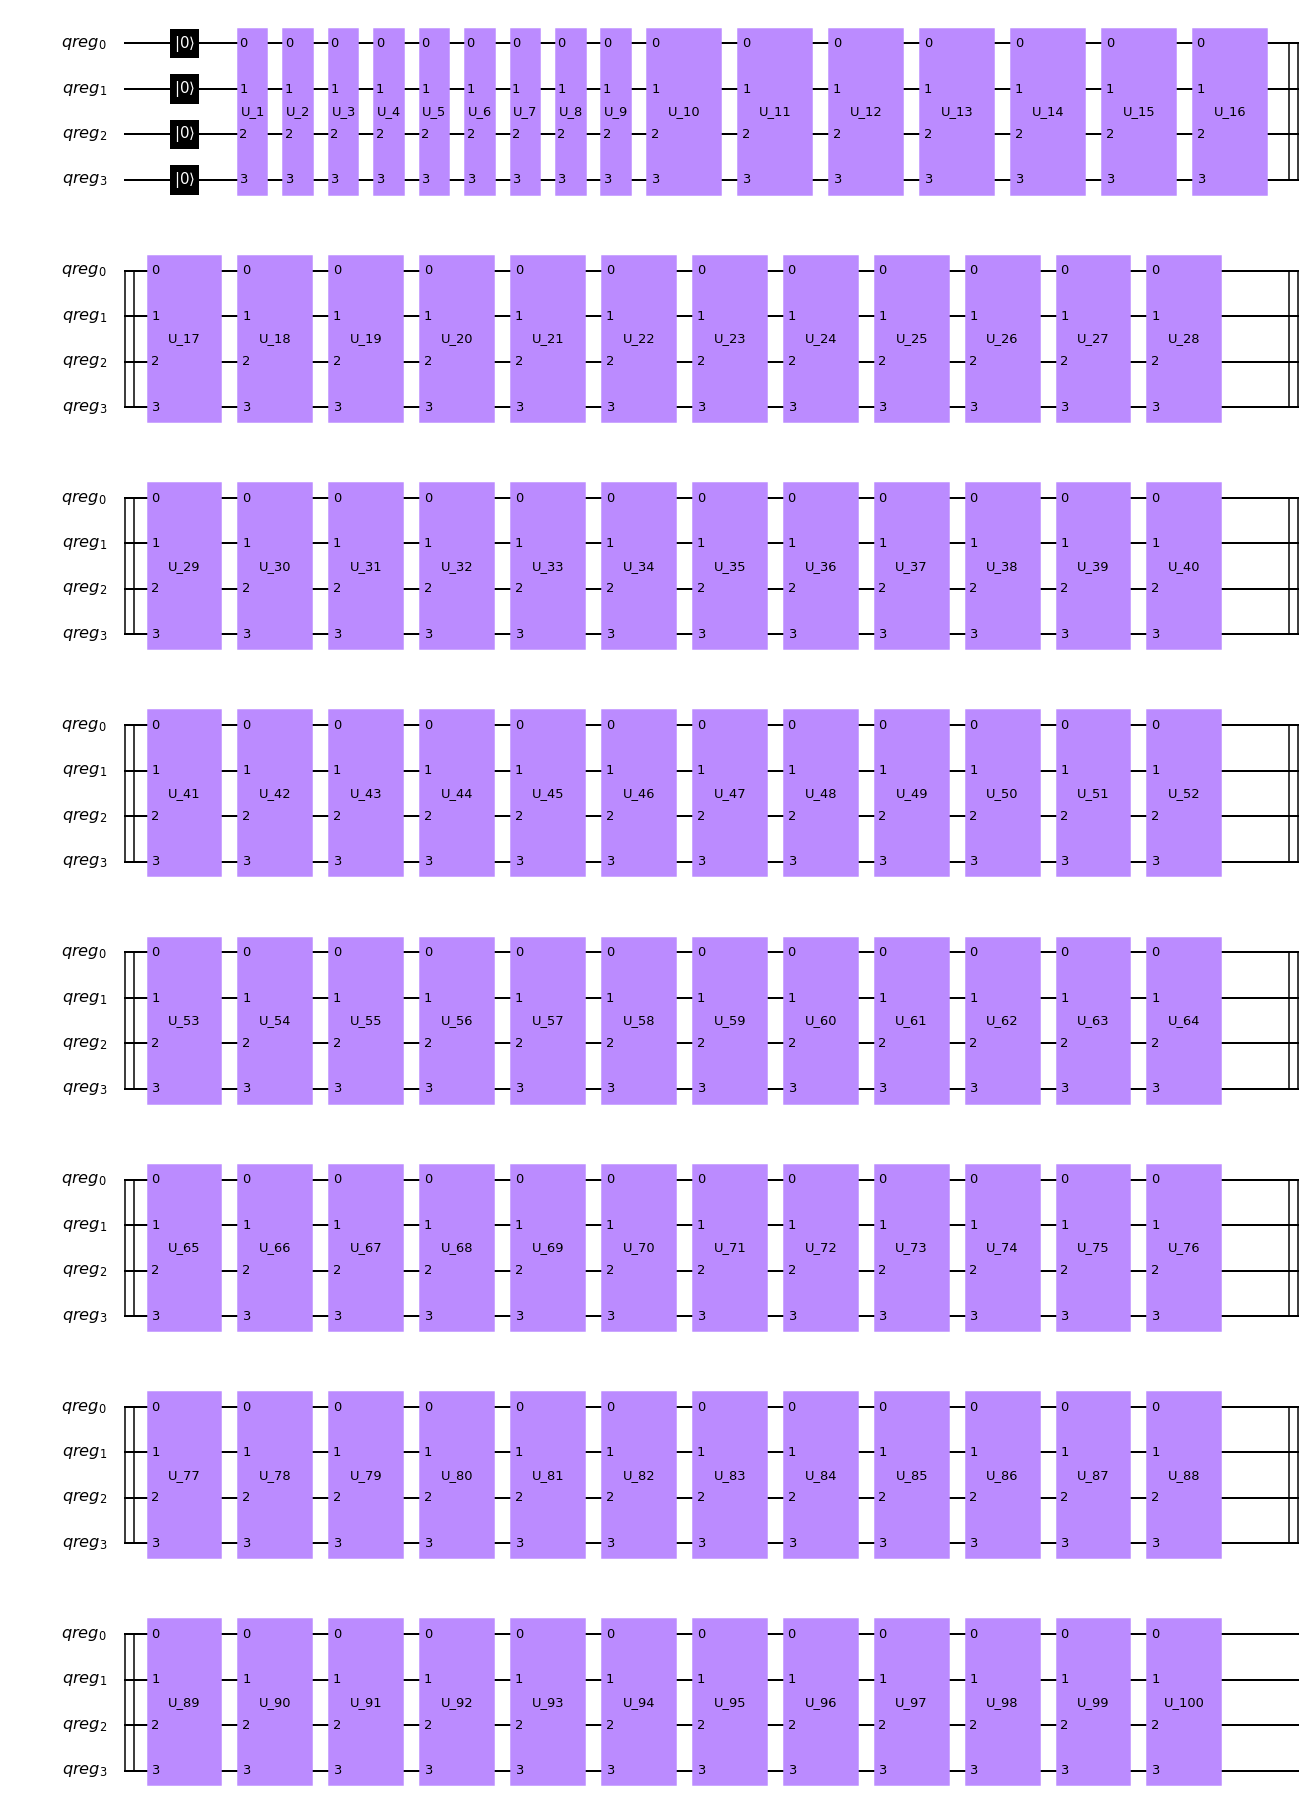

In [13]:
qc.draw('mpl')

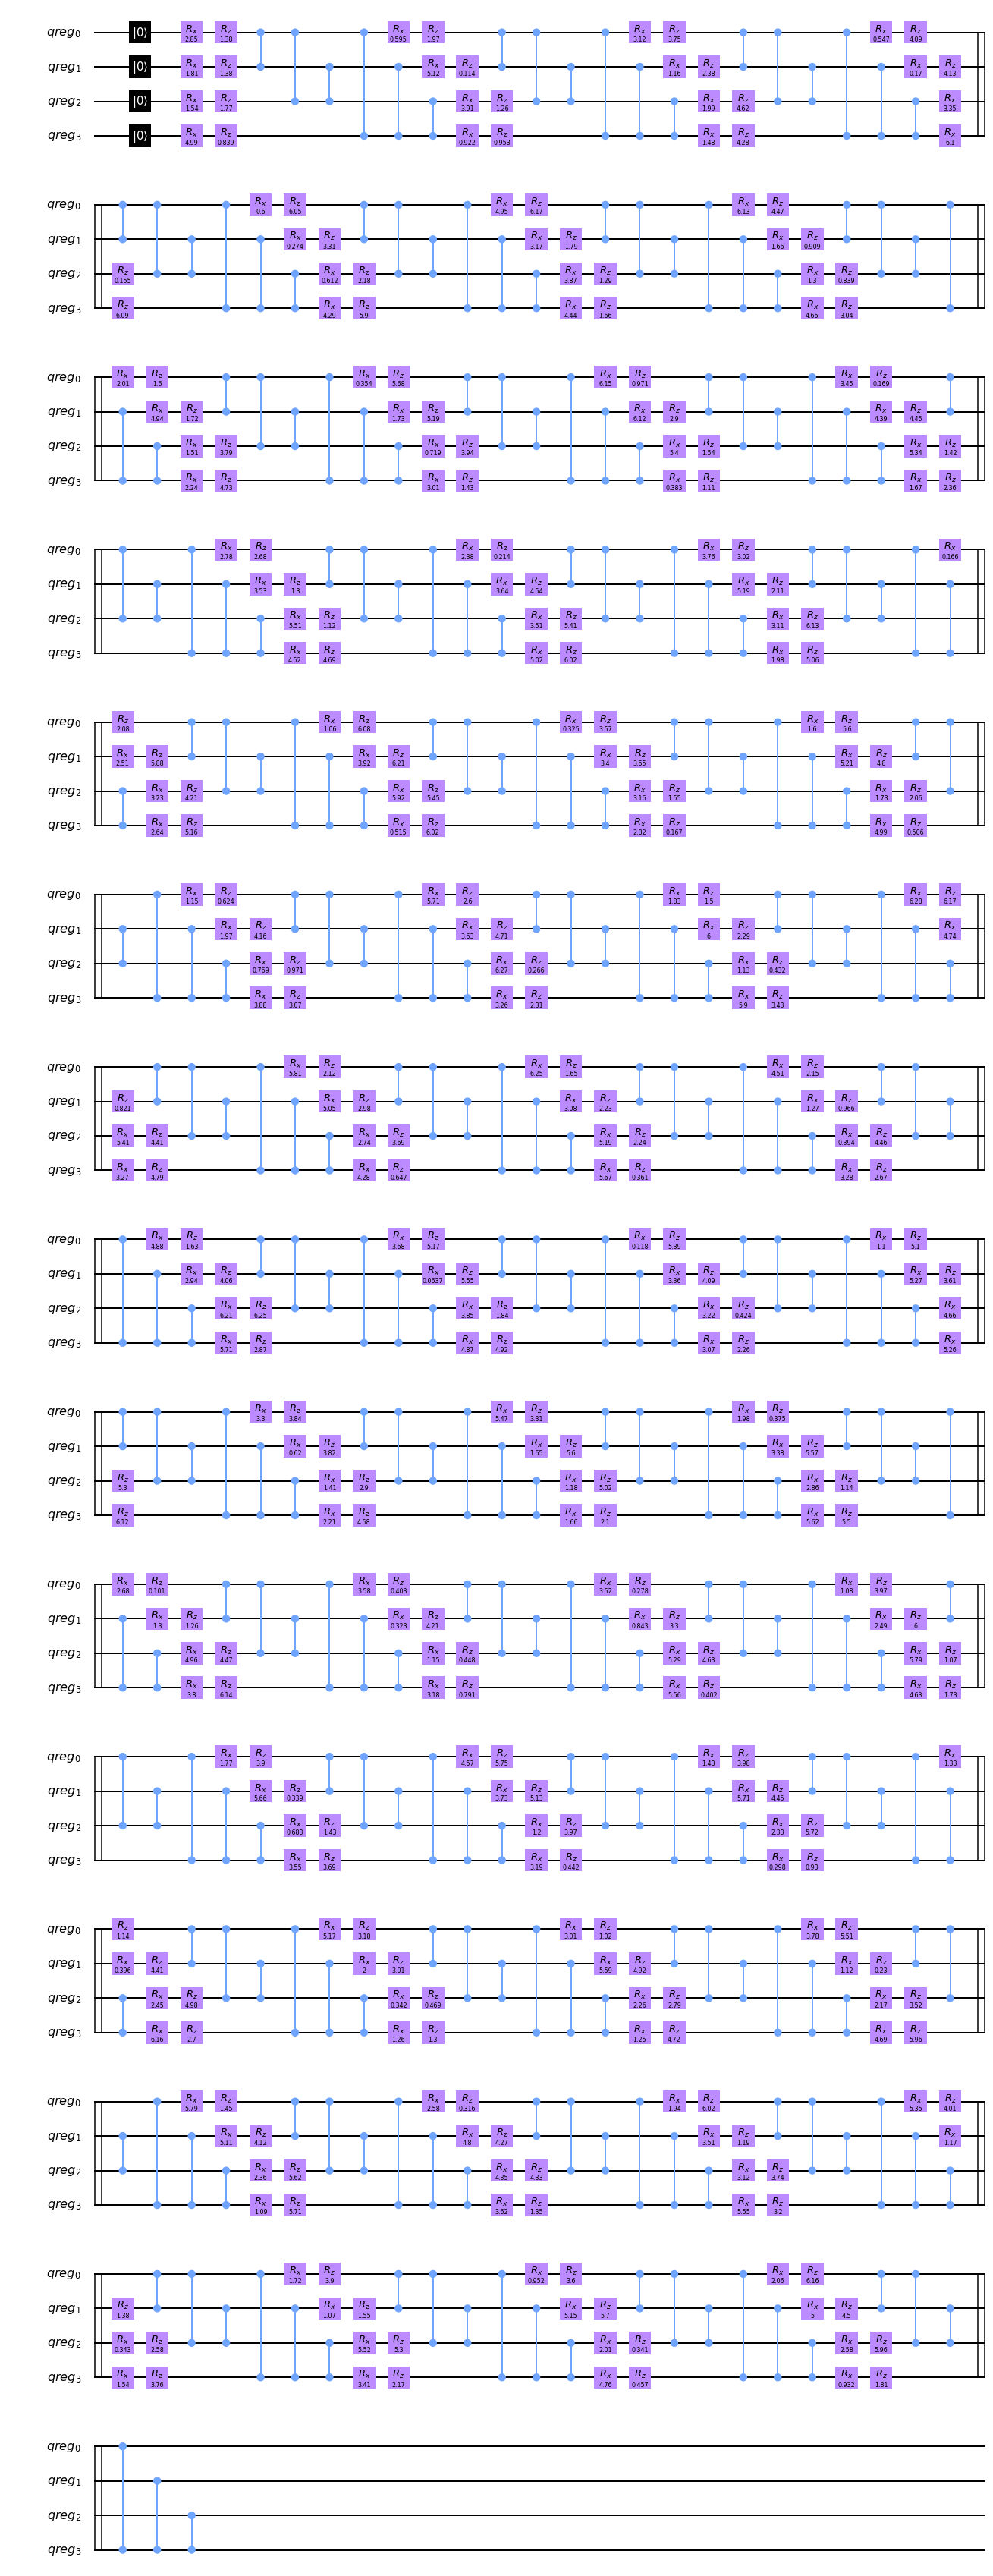

In [14]:
qc.decompose().draw('mpl')